# Train and Evaluate a Pytorch model

In [1]:
import pathlib
from pprint import pprint
from matplotlib import pyplot as plt
from lips.benchmark import PowerGridBenchmark

In [2]:
# indicate required paths
LIPS_PATH = pathlib.Path().resolve().parent
DATA_PATH = LIPS_PATH / "reference_data"
LOG_PATH = LIPS_PATH / "lips_logs.log"
CONFIG_PATH = LIPS_PATH / "lips" / "config" / "conf.ini"
BASELINES_PATH = LIPS_PATH / "trained_baselines"
TRAINED_MODEL_PATH = LIPS_PATH / "trained_models"

In [ ]:
benchmark1 = PowerGridBenchmark(benchmark_name="Benchmark1",
                                benchmark_path=DATA_PATH,
                                load_data_set=True,
                                log_path=LOG_PATH,
                                config_path=CONFIG_PATH
                               )

## Instantiate the torch model

In [4]:
from lips.augmented_simulators.torch_models.fully_connected import TorchFullyConnected
from lips.augmented_simulators.torch_simulator import TorchSimulator
from lips.dataset import Scaler

In [5]:
params = {"input_size": benchmark1.train_dataset._size_x, "output_size": benchmark1.train_dataset._size_y}
torch_sim = TorchSimulator(name="torch_fc",
                           model=TorchFullyConnected,
                           scaler=Scaler,
                           log_path=LOG_PATH,
                           **params)

Verify the model architecture

In [6]:
torch_sim.summary()

TorchFullyConnected(
  (input_layer): Linear(in_features=111, out_features=300, bias=True)
  (input_dropout): Dropout(p=0.0, inplace=False)
  (fc_layers): ModuleList(
    (0): Linear(in_features=300, out_features=300, bias=True)
    (1): Linear(in_features=300, out_features=300, bias=True)
    (2): Linear(in_features=300, out_features=300, bias=True)
  )
  (dropout_layers): ModuleList(
    (0): Dropout(p=0.0, inplace=False)
    (1): Dropout(p=0.0, inplace=False)
    (2): Dropout(p=0.0, inplace=False)
  )
  (output_layer): Linear(in_features=300, out_features=40, bias=True)
)


In [7]:
print("Number of parameters of the model: ", torch_sim.count_parameters())

Number of parameters of the model:  316540


The parameters used for training and evaluation of this augmented simulator.

In [8]:
pprint(torch_sim.params)

{'activation': 'relu',
 'ckpt_freq': 50,
 'device': 'cpu',
 'dropout': 0.0,
 'epochs': 10,
 'eval_batch_size': 128,
 'input_dropout': 0.0,
 'input_size': 111,
 'layer': 'linear',
 'layers': (300, 300, 300, 300),
 'loss': {'name': 'MSELoss',
          'params': {'reduce': None,
                     'reduction': 'mean',
                     'size_average': None}},
 'metrics': ('MAELoss',),
 'name': 'torch_fc',
 'optimizer': {'name': 'adam', 'params': {'lr': 0.0003}},
 'output_size': 40,
 'save_freq': False,
 'shuffle': False,
 'train_batch_size': 128}


### Train it 

In [9]:
torch_sim.train(benchmark1.train_dataset, benchmark1.val_dataset, epochs=10, save_path=None)

Train Epoch: 1   Avg_Loss: 0.11168 ['MAELoss: 0.16884']
Eval:   Avg_Loss: 0.01851 ['MAELoss: 0.08593']
Train Epoch: 2   Avg_Loss: 0.00948 ['MAELoss: 0.06395']
Eval:   Avg_Loss: 0.00957 ['MAELoss: 0.06223']
Train Epoch: 3   Avg_Loss: 0.00595 ['MAELoss: 0.05080']
Eval:   Avg_Loss: 0.00596 ['MAELoss: 0.04881']
Train Epoch: 4   Avg_Loss: 0.00428 ['MAELoss: 0.04456']
Eval:   Avg_Loss: 0.00415 ['MAELoss: 0.04139']
Train Epoch: 5   Avg_Loss: 0.00359 ['MAELoss: 0.04104']
Eval:   Avg_Loss: 0.00334 ['MAELoss: 0.03724']
Train Epoch: 6   Avg_Loss: 0.00295 ['MAELoss: 0.03750']
Eval:   Avg_Loss: 0.00279 ['MAELoss: 0.03418']
Train Epoch: 7   Avg_Loss: 0.00316 ['MAELoss: 0.03764']
Eval:   Avg_Loss: 0.00215 ['MAELoss: 0.03001']
Train Epoch: 8   Avg_Loss: 0.00242 ['MAELoss: 0.03390']
Eval:   Avg_Loss: 0.00193 ['MAELoss: 0.02871']
Train Epoch: 9   Avg_Loss: 0.00279 ['MAELoss: 0.03499']
Eval:   Avg_Loss: 0.00167 ['MAELoss: 0.02715']
Train Epoch: 10   Avg_Loss: 0.00204 ['MAELoss: 0.03148']
Eval:   Avg_Loss

#### Visualize the performance 

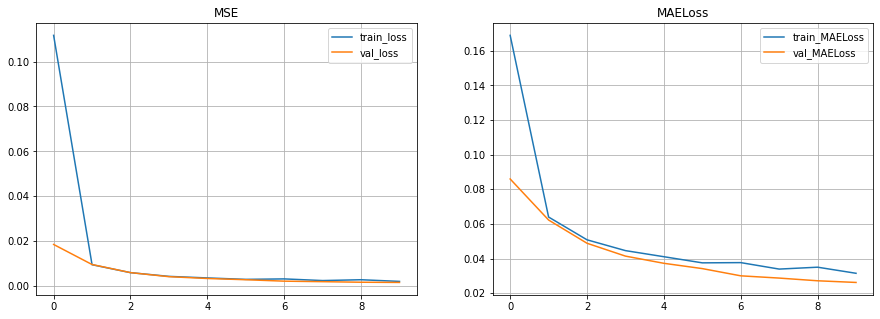

In [10]:
torch_sim.visualize_convergence()

## Evaluate

In [ ]:
# TODO: log the losses
torch_sim_metrics = benchmark1.evaluate_simulator(augmented_simulator=torch_sim,
                                                  eval_batch_size=128,
                                                  dataset="all",
                                                  shuffle=False
                                                 )

In [12]:
torch_sim_metrics["test"]["ML"]

{'MSE_avg': {'a_or': 35.49590301513672, 'a_ex': 90.90232849121094},
 'MAE_avg': {'a_or': 3.510498523712158, 'a_ex': 5.093857288360596},
 'mape_90_avg': {'a_or': 0.010410443022903055, 'a_ex': 0.010579427028622367}}

In [13]:
torch_sim_metrics["test_ood_topo"]["ML"]

{'MSE_avg': {'a_or': 6673.7373046875, 'a_ex': 11585.724609375},
 'MAE_avg': {'a_or': 33.74958038330078, 'a_ex': 46.697532653808594},
 'mape_90_avg': {'a_or': 0.15009300982318693, 'a_ex': 0.15039980314217619}}

## Save & Load 

In [14]:
torch_sim.save(TRAINED_MODEL_PATH)

Load it

In [15]:
from lips.augmented_simulators.torch_models.fully_connected import TorchFullyConnected
from lips.augmented_simulators.torch_simulator import TorchSimulator
from lips.dataset import Scaler

params = {"input_size": benchmark1.train_dataset._size_x, "output_size": benchmark1.train_dataset._size_y}
torch_sim_test = TorchSimulator(name="torch_fc",
                           model=TorchFullyConnected,
                           scaler=Scaler,
                           log_path=LOG_PATH,
                           **params)

In [17]:
torch_sim_test.restore(path=TRAINED_MODEL_PATH)

# Train and evaluate a tensorflow model 

In [4]:
from lips.dataset import Scaler
from lips.augmented_simulators.tensorflow_models import TfFullyConnected
from lips.augmented_simulators.tensorflow_simulator import TensorflowSimulator

In [ ]:
params = {"input_shape": (benchmark1.train_dataset._size_x,), "output_size": benchmark1.train_dataset._size_y}
tf_sim = TensorflowSimulator(name="tf_fc",
                             model=TfFullyConnected,
                             scaler=Scaler,
                             log_path=LOG_PATH,
                             **params)

In [6]:
tf_sim.params

{'input_shape': (111,),
 'output_size': 40,
 'name': 'tf_fc',
 'layers': (300, 300, 300, 300),
 'activation': 'relu',
 'layer': 'linear',
 'input_dropout': 0.0,
 'dropout': 0.0,
 'metrics': ['mae'],
 'loss': {'name': 'mse',
  'params': {'size_average': None, 'reduce': None, 'reduction': 'mean'}},
 'device': 'cpu',
 'optimizers': {'name': 'adam', 'params': {'lr': 0.0003}},
 'train_batch_size': 128,
 'eval_batch_size': 128,
 'epochs': 5,
 'shuffle': True,
 'save_freq': False,
 'ckpt_freq': 50}

In [7]:
tf_sim._model.summary()

Model: "tf_fc_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 111)]             0         
                                                                 
 input_dropout (Dropout)     (None, 111)               0         
                                                                 
 layer_0 (Dense)             (None, 300)               33600     
                                                                 
 activation_0 (Activation)   (None, 300)               0         
                                                                 
 dropout_0 (Dropout)         (None, 300)               0         
                                                                 
 layer_1 (Dense)             (None, 300)               90300     
                                                                 
 activation_1 (Activation)   (None, 300)               

In [8]:
print("Number of parameters :", tf_sim.count_parameters())

Number of parameters : 316540


In [9]:
history = tf_sim.train(benchmark1.train_dataset, benchmark1.val_dataset, save_path=None, epochs=10)

Epoch 1/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0738 - mae: 0.1360 - val_loss: 0.0102 - val_mae: 0.0679
Epoch 2/10
782/782 [==============================] - 6s 7ms/step - loss: 0.0056 - mae: 0.0531 - val_loss: 0.0049 - val_mae: 0.0480
Epoch 3/10
782/782 [==============================] - 8s 10ms/step - loss: 0.0034 - mae: 0.0419 - val_loss: 0.0038 - val_mae: 0.0436
Epoch 4/10
782/782 [==============================] - 7s 8ms/step - loss: 0.0025 - mae: 0.0358 - val_loss: 0.0029 - val_mae: 0.0380
Epoch 5/10
782/782 [==============================] - 6s 8ms/step - loss: 0.0020 - mae: 0.0321 - val_loss: 0.0022 - val_mae: 0.0327
Epoch 6/10
782/782 [==============================] - 6s 7ms/step - loss: 0.0017 - mae: 0.0297 - val_loss: 0.0020 - val_mae: 0.0313
Epoch 7/10
782/782 [==============================] - 5s 7ms/step - loss: 0.0015 - mae: 0.0280 - val_loss: 0.0018 - val_mae: 0.0301
Epoch 8/10
782/782 [==============================] - 6s 8ms/step - loss: 0

Save a visulaization of the architecture on disk

In [10]:
tf_sim.plot_model(path=".")

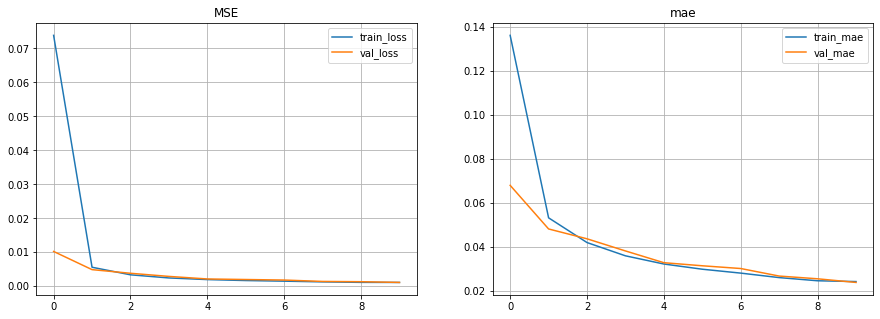

In [11]:
tf_sim.visualize_convergence()

In [ ]:
# TODO: log the losses
tf_sim_metrics = benchmark1.evaluate_simulator(augmented_simulator=tf_sim,
                                               eval_batch_size=128,
                                               dataset="all",
                                               shuffle=False
                                              )

In [13]:
tf_sim_metrics["test"]["ML"]

{'MSE_avg': {'a_or': 24.055461883544922, 'a_ex': 58.6097526550293},
 'MAE_avg': {'a_or': 3.150585651397705, 'a_ex': 4.493765354156494},
 'mape_90_avg': {'a_or': 0.008634400297121484, 'a_ex': 0.008678767580653179}}

In [14]:
tf_sim_metrics["test_ood_topo"]["ML"]

{'MSE_avg': {'a_or': 9323.931640625, 'a_ex': 17878.96484375},
 'MAE_avg': {'a_or': 45.976173400878906, 'a_ex': 65.44258117675781},
 'mape_90_avg': {'a_or': 0.21105129734636124, 'a_ex': 0.2100863433099883}}

In [15]:
tf_sim.predict_time

0.27944326400756836

## Save & Load 

In [16]:
tf_sim.save(TRAINED_MODEL_PATH)

Load it

In [ ]:
from lips.augmented_simulators.tensorflow_models import TfFullyConnected
from lips.augmented_simulators.tensorflow_simulator import TensorflowSimulator
from lips.dataset import Scaler

params = {"input_shape": (benchmark1.train_dataset._size_x,), "output_size": benchmark1.train_dataset._size_y}
tf_sim_test = TensorflowSimulator(name="tf_fc",
                                  model=TfFullyConnected,
                                  scaler=Scaler,
                                  log_path=LOG_PATH,
                                  **params)

In [5]:
tf_sim_test.restore(path=TRAINED_MODEL_PATH)